### ABテスト結果の分散比較
#### S-C-Q整理
- Situation
  - ABテストの結果を評価する際、各群の平均値を比較して意思決定を行う。
- Complication
   - ただし、事前値の群間差が大きい場合、単純比較ではその影響を受け、テスト結果を正確に評価できないことで意思決定を誤る可能性が懸念される。
- Question
  - 事前値の群間差を考慮して平均差を精緻に推定し、適切な意思決定につなげる可能性を高めるにはどの方法を用いるべきか？
    - 各方法における推定量の分散の大小で判断を行う
    - 推定量は不偏である前提とする
- Answer (このNotebookでやること)
  - 以下2つの手法における推定量の分散を比較する。
    - 単純平均比較
    - 施策前目的変数を共変量として使用する手法
  - Output
    - 各手法による推定量の分散
    - より好ましいと判断された手法
  - 判断基準
    - 分散が小さい方をより好ましい手法とする

#### 理論的考察
前提
- $Y$: 施策後目的変数
- $X$: 施策前目的変数
  - $Y$と$X$には一定の相関があるものとする
- $T$: 処置有無
- 添字
  - $_T$: Treatment群
  - $_C$: Control群
  - $_i$: ユーザー

単純平均
- $\hat{\tau}_{avg} = \bar{Y}_{T} - \bar{Y}_{C}$
- $V[\hat{\tau}_{avg}] = V[\bar{Y}_{T} - \bar{Y}_{C}] = V[\bar{Y}_{T}] + V[\bar{Y}_{C}]$
  - ∵ $Y_{T}$と$Y_{C}$は独立

施策前目的変数を共変量として使用する手法
- 回帰モデル: $Y_{i} = \beta_{0} + \beta_{1} \cdot X_{i} + \tau_{i} \cdot T_{i} + u_{i}$ より$\beta_{0}$・$\beta_{1}$を考える
- $Y_{T,i} = \beta_{0} + \beta_{1} \cdot X_{T,i} + \tau_{T,i} + u_{T,i}$
  - $\bar{Y}_{T} = \beta_{0} + \beta_{1} \cdot \bar{X}_{T} + \bar{\tau}_{T}$
    - $E[u_{T,i}] = 0 とする$
    - $E[\tau_{T,i}] = \bar{\tau}_{T} とする$
- $Y_{C,i} = \beta_{0} + \beta_{1} \cdot X_{C,i} + u_{C,i}$
  - $\bar{Y}_{C} = \beta_{0} + \beta_{1} \cdot \bar{X}_{C}$
      - $E[u_{C,i}] = 0 とする$
- $\hat{\tau}_{new} = \bar{Y}_{T} - \bar{Y}_{C} - \hat{\beta}_{1}(\bar{X}_{T} - \bar{X}_{C}) $
- $V[\hat{\tau}_{new}]$
  - $= V[\bar{Y}_{T} - \bar{Y}_{C} - \hat{\beta}_{1}(\bar{X}_{T} - \bar{X}_{C})]$
  - $= V[\bar{Y}_{T}] + V[\bar{Y}_{C}] + \hat{\beta}_{1}^2 \cdot V[\bar{X}_{T}] + \hat{\beta}_{1}^2 \cdot V[\bar{X}_{C}] - 2\hat{\beta}_{1}cov(\bar{Y}_{T}, \bar{X}_{T}) - 2\hat{\beta}_{1}cov(\bar{Y}_{C}, \bar{X}_{C})$
    - ∵ $Y_{T}$と$Y_{C}$は独立・$X_{T}$と$X_{C}$は独立
    - ∵ $\hat{\beta}_{1} = cov(\bar{Y}_{T}, \bar{X}_{T}) / V[\bar{Y}_{T}] =cov(\bar{Y}_{C}, \bar{X}_{C}) / V[\bar{Y}_{C}] $
  - $≒ V[\bar{Y}_{T}] + V[\bar{Y}_{C}] \color{#1f77b4}- cov(\bar{Y}_{T}, \bar{X}_{T})^2 / V[\bar{Y}_{T}] - cov(\bar{Y}_{C}, \bar{X}_{C})^2 / V[\bar{Y}_{C}] $
    - 色がついている$\color{#1f77b4}cov(\bar{Y}_{T}, \bar{X}_{T})$・$\color{#1f77b4}cov(\bar{Y}_{C}, \bar{X}_{C})$がどちらも0でなければ、分散削減が可能と考えられる
    - ここで$\hat{\beta}_{1}$はOLS推定量であり、大標本では真の$\beta_{1}$に収束するので、近似的に上式が成り立つ

In [163]:
# モジュールインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from tqdm import tqdm

from utils import generate_data,return_avg_tau,return_ols_tau,return_true_tau,plot_histgram,calc_var,calc_prop_near

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:00<00:00, 937.62it/s]


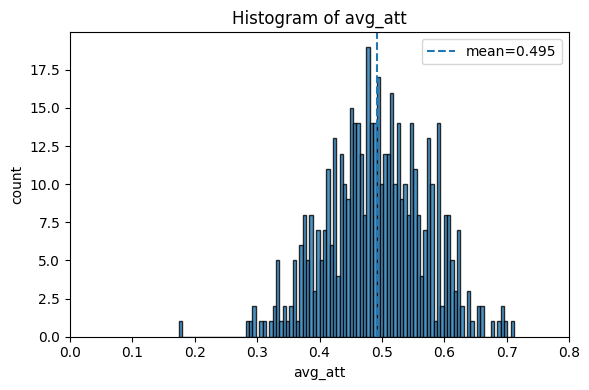

不偏分散: 0.00633
0.4-0.6の割合: 0.778


In [165]:
# 単純集計で500回推定トライアル
n_trials = 500
avg_att_list = []
true_tau_list = []
for i in tqdm(range(n_trials)):
    df = generate_data(seed=i)
    avg_att = return_avg_tau(df)
    avg_att_list.append(avg_att)
    true_tau = return_true_tau(df)
    true_tau_list.append(true_tau)

plot_histgram(avg_att_list,true_tau_list)

var_sam = calc_var(avg_att_list)
print(f'不偏分散: {var_sam:,.5f}')

# 真の値0.5に対して、0.4-0.6と推定できている割合
prop = calc_prop_near(avg_att_list)
print(f'0.4-0.6の割合: {prop:,.3f}')

100%|██████████| 500/500 [00:00<00:00, 706.01it/s]


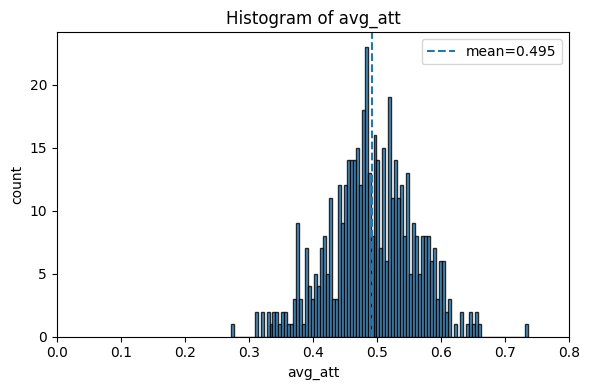

不偏分散: 0.00462
0.4-0.6の割合: 0.858


In [166]:
# 回帰モデルを用いた推定で500回推定トライアル
n_trials = 500
avg_att_list = []
true_tau_list = []
for i in tqdm(range(n_trials)):
    df = generate_data(seed=i)
    avg_att = return_ols_tau(df)
    avg_att_list.append(avg_att)
    true_tau = return_true_tau(df)
    true_tau_list.append(true_tau)

plot_histgram(avg_att_list,true_tau_list)

var_sam = calc_var(avg_att_list)
print(f'不偏分散: {var_sam:,.5f}')

# 真の値0.5に対して、0.4-0.6と推定できている割合
prop = calc_prop_near(avg_att_list)
print(f'0.4-0.6の割合: {prop:,.3f}')

#### 結論
- Answer (このNotebookでやること)
  - 以下2つの手法における推定量の分散を比較する。
    - 単純平均比較
    - 施策前目的変数を共変量として使用する手法
  - Output
    - 各手法による推定量の分散
      - 単純平均比較
        - <span style="color:#1f77b4">0.00633</span>
      - 施策前目的変数を共変量として使用する手法
        - <span style="color:#1f77b4">0.00462</span>
    - より好ましいと判断された手法
      - <span style="color:#1f77b4">施策前目的変数を共変量として使用する手法</span>
  - 判断基準
    - 分散が小さい方をより好ましい手法とする

In [162]:
# 余談: 施策前目的変数（X）が乖離してしまった2群に対して、回帰モデルを使用した方が上手く推定できるのか？
# →ランダム割り付けが正常になされていつつも「乖離してしまった」ものとする

# ケースi: 施策前目的変数が「Tr > Cr」
print('======================================================================')
print('ケースi')
print('======================================================================')
df = generate_data(seed=9)
display(df.groupby('T').mean())
X_diff = df[df['T']==1]['X'].mean() - df[df['T']==0]['X'].mean()
print(f'→Xの差分（Tr-Cr）が{X_diff:,.2f}と乖離している')
print('')
avg_att = return_avg_tau(df)
print(f'単純比較による効果推定値: {avg_att:,.3f}')

avg_att = return_ols_tau(df)
print(f'回帰モデルによる効果推定値: {avg_att:,.3f}')
print('')
print('→回帰モデルを用いる方が真の効果に近い値を推定できている')
print('')

# ケースii: 施策前目的変数が「Tr < Cr」
print('======================================================================')
print('ケースii')
print('======================================================================')
df = generate_data(seed=226)
display(df.groupby('T').mean())
X_diff = df[df['T']==1]['X'].mean() - df[df['T']==0]['X'].mean()
print(f'→Xの差分（Tr-Cr）が{X_diff:,.2f}と乖離している')
print('')
avg_att = return_avg_tau(df)
print(f'単純比較による効果推定値: {avg_att:,.3f}')

avg_att = return_ols_tau(df)
print(f'回帰モデルによる効果推定値: {avg_att:,.3f}')
print('')
print('→回帰モデルを用いる方が真の効果に近い値を推定できている')

ケースi


,X,Y0,tau,Y1,Y
T,,,,,
0,-0.115150,-0.051390,0.486065,0.434675,-0.05139
1,0.128294,0.106238,0.497632,0.603870,0.60387


→Xの差分（Tr-Cr）が0.24と乖離している

単純比較による効果推定値: 0.655
回帰モデルによる効果推定値: 0.490

→回帰モデルを用いる方が真の効果に近い値を推定できている

ケースii


,X,Y0,tau,Y1,Y
T,,,,,
0,0.103472,0.065334,0.591471,0.656805,0.065334
1,-0.091197,-0.058239,0.510950,0.452711,0.452711


→Xの差分（Tr-Cr）が-0.19と乖離している

単純比較による効果推定値: 0.387
回帰モデルによる効果推定値: 0.510

→回帰モデルを用いる方が真の効果に近い値を推定できている
